# First time delay observation between two mid-infrared channels in solar flare footpoints

In [14]:
#Depending on the sections you use, you may need the following libraries
#!pip install sunpy[all]
#!pip install radyn-xtools
#!pip install lightweaver

In [15]:
import os
from os.path import dirname, join as pjoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import glob
%matplotlib inline

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import time_support
from astropy.io import fits

from datetime import datetime, timedelta

import sunpy.map
from sunpy import timeseries as ts
from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.coordinates import frames

import scipy.io as sio
from scipy.io import readsav
from scipy import signal
from scipy import stats
from scipy import integrate
from scipy.optimize import curve_fit
import scipy.constants as const

import pickle
import math

from typing import List

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
folder= "/content/drive/Othercomputers/UofG_Computer/IR/Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"
#folder=r"G:\Other computers\UofG_Computer\IR\Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"
#folder=r"C:\Users\migue\OneDrive - University of Glasgow\IR\Delay-observations-mid-infrared-channels-in-solar-flare-footpoints"

#DESCRIPTION OF OBSERVATIONS

In [18]:
# Colourblind-friendly palette from colour universal design (CUD)
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']


# https://jfly.uni-koeln.de/color/
named_colors = {"black": "#000000",
    "orange": "#e69f00",
    "skyblue": "#56b4e9",
    "bluish green": "#009e73",
    "yellow": "#f0e442",
    "blue": "#0072b2",
    "vermilion": "#d55e00",
    "reddish purple": "#cc79a7",
}
cud_palette = list(named_colors.values())


def cud(n: int = len(cud_palette), start: int = 0) -> List[str]:
    remainder = cud_palette[:start]
    palette = cud_palette[start:] + remainder
    return palette[:n]

palette = cud()

In [19]:
df_10 = pd.read_csv(f"{folder}/intensity_data_10um.csv", parse_dates=['time_10'])
df_05 = pd.read_csv(f"{folder}/intensity_data_05um.csv", parse_dates=['time_05'])

sp_I_10 = df_10['sp_I_10'].values
fA_I_10 = df_10['fA_I_10'].values
fB_I_10 = df_10['fB_I_10'].values
qs_I_10 = df_10['qs_I_10'].values
time_10 = df_10['time_10']

sp_I_05 = df_05['sp_I_05'].values
fA_I_05 = df_05['fA_I_05'].values
fB_I_05 = df_05['fB_I_05'].values
qs_I_05 = df_05['qs_I_05'].values
time_05 = df_05['time_05']

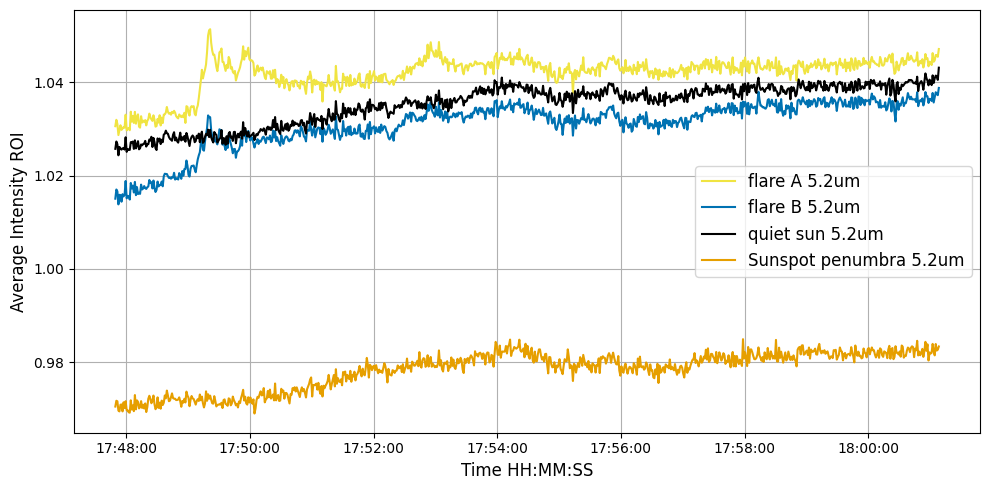

In [20]:
plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_05, fA_I_05, color=palette[4], label='flare A 5.2um')
plt.plot(time_05, fB_I_05, color=palette[5], label='flare B 5.2um')
plt.plot(time_05, qs_I_05, color=palette[0], label='quiet sun 5.2um')
plt.plot(time_05, sp_I_05, color=palette[1], label='Sunspot penumbra 5.2um')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12)#,loc='lower right')
plt.tight_layout()

plt.show()

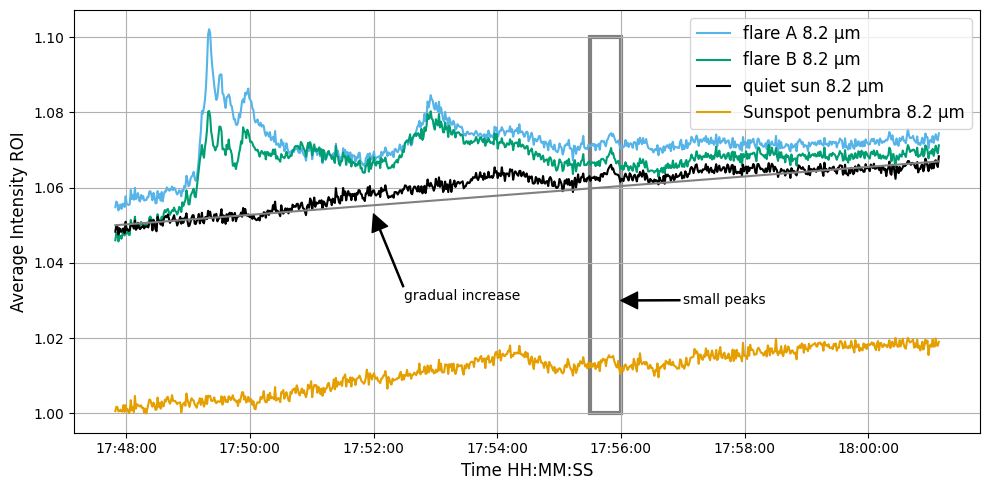

In [21]:
y=np.arange(0, len(time_10), 1)*((1.067-1.05)/len(time_10))+1.05 #Linear estimate of the  gradual increase in intensity.

plt.figure(figsize=(10, 5))
plt.xlabel('Time HH:MM:SS',fontsize=12)
plt.ylabel('Average Intensity ROI',fontsize=12)

plt.plot(time_10, fA_I_10, color=palette[2], label='flare A 8.2 µm')
plt.plot(time_10, fB_I_10, color=palette[3], label='flare B 8.2 µm')
plt.plot(time_10, qs_I_10, color=palette[0], label='quiet sun 8.2 µm')
plt.plot(time_10, sp_I_10, color=palette[1], label='Sunspot penumbra 8.2 µm')

plt.plot(time_10, y, 'grey')
plt.annotate('gradual increase', xy=(datetime(2014,9,24,17,52,00), 1.053), xytext=(datetime(2014,9,24,17,52,30), 1.03), arrowprops=dict(facecolor='k', width=0.8), size=10)
plt.gca().add_patch(Rectangle((datetime(2014,9,24,17,55,30), 1), datetime(2014,9,24,17,52,30)-datetime(2014,9,24,17,52,00),0.1, edgecolor = 'grey', facecolor = 'blue', fill=False, lw=3))
plt.annotate('small peaks', xy=(datetime(2014,9,24,17,56,00), 1.03), xytext=(datetime(2014,9,24,17,57,0), 1.029), arrowprops=dict(facecolor='k', width=0.8), size=10)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)
plt.grid(True)
plt.legend(fontsize=12,loc='upper right')
plt.tight_layout()

plt.show()

#### GOES data

In [22]:
file_goes15 = f"{folder}/goes_data.nc"
goes_15 = ts.TimeSeries(file_goes15)

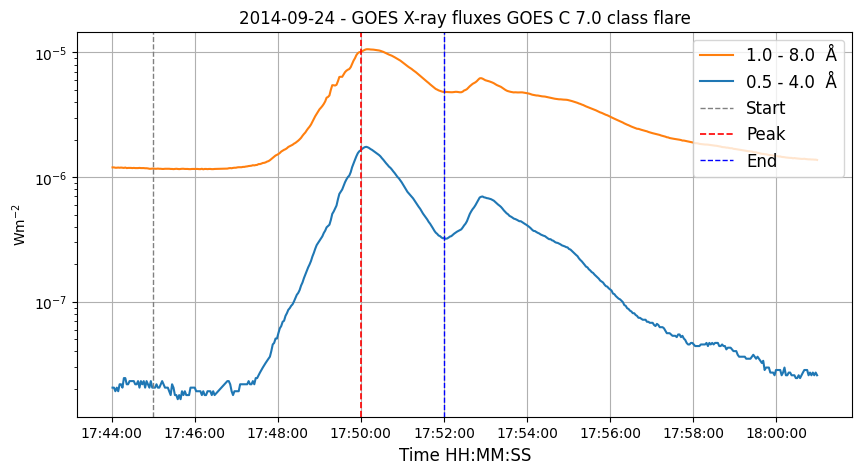

In [23]:
from datetime import datetime

df = goes_15.to_dataframe()
goes_15 = ts.TimeSeries(df, goes_15.meta, goes_15.units)

goes_flare = goes_15.truncate("2014-09-24 17:44", "2014-09-24 18:01")
time_support()

fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title("2014-09-24 - GOES X-ray fluxes GOES C 7.0 class flare")

ax.plot(goes_flare.time.datetime, goes_flare.quantity("xrsb"), label = "1.0 - 8.0  Å", color="C1")
ax.plot(goes_flare.time.datetime, goes_flare.quantity("xrsa"), label ="0.5 - 4.0  Å", color="C0")

ax.set_ylabel("Wm$^{-2}$")

# Líneas verticales
# Convertir cada Time a datetime compatible con matplotlib
from astropy.time import Time

start = Time('2014-09-24T17:45:00')
peak  = Time('2014-09-24T17:50:00')
end   = Time('2014-09-24T17:52:00')

ax.axvline(start.datetime, color="grey", linestyle="--", linewidth=1, label="Start")
ax.axvline(peak.datetime,  color="red",  linestyle="--", linewidth=1.2, label="Peak")
ax.axvline(end.datetime,   color="blue", linestyle="--", linewidth=1, label="End")

ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax.grid(True)

ax.legend(fontsize=12, loc='upper right')
ax.set_xlabel('Time HH:MM:SS', fontsize=12)
ax.set_yscale('log')

plt.show()

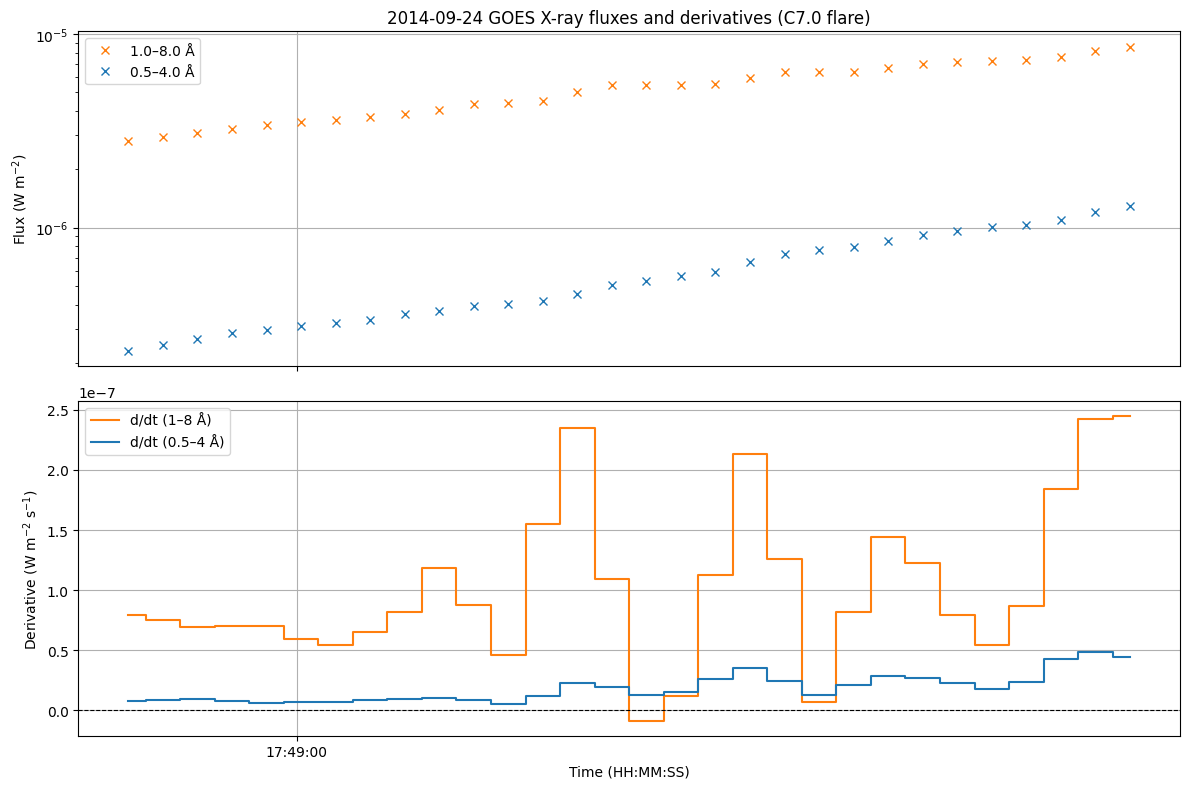

In [24]:
# --- DataFrame ---
df = goes_15.to_dataframe()
goes_15 = ts.TimeSeries(df, goes_15.meta, goes_15.units)

goes_flare = goes_15.truncate("2014-09-24 17:48:50", "2014-09-24 17:49:50")

# === Original Data ===
times = goes_flare.time.datetime
flux_a = goes_flare.quantity("xrsa").value   # 1-8 Å
flux_b = goes_flare.quantity("xrsb").value   # 0.5-4 Å

# === Derivatives ===
# convert datetime to seconds relative to t0
t_seconds = (times - times[0]).astype("timedelta64[s]").astype(float)

dflux_a = np.gradient(flux_a, t_seconds)  # d(flux)/dt
dflux_b = np.gradient(flux_b, t_seconds)
# Gradient in numpy uses: second-order accurate central difference

# === Plot ===
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Panel 1: Flux
ax1.set_title("2014-09-24 GOES X-ray fluxes and derivatives (C7.0 flare)")
ax1.plot(times, flux_b, 'x',label="1.0–8.0 Å", color="C1")
ax1.plot(times, flux_a,'x', label="0.5–4.0 Å", color="C0")
ax1.set_ylabel("Flux (W m$^{-2}$)")
ax1.set_yscale("log")
ax1.legend()
ax1.grid(True)

# Panel 2: Derivatives
ax2.step(times, dflux_b, where='mid', color="C1", label="d/dt (1–8 Å)")
ax2.step(times, dflux_a, where='mid', color="C0", label="d/dt (0.5–4 Å)")

ax2.axhline(0, color="k", linestyle="--", linewidth=0.8)
ax2.set_ylabel("Derivative (W m$^{-2}$ s$^{-1}$)")
ax2.legend()
ax2.grid(True)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax2.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax2.set_xlabel("Time (HH:MM:SS)")

plt.tight_layout()
plt.show()

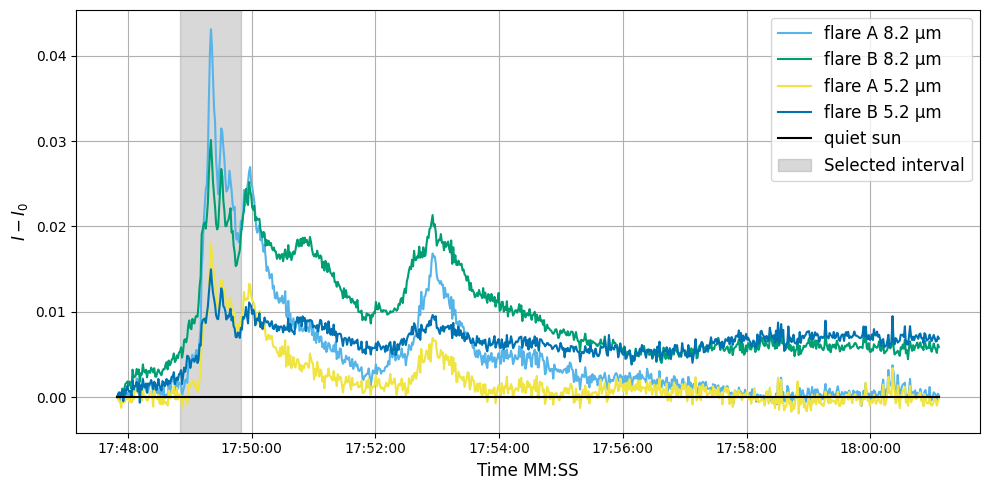

In [25]:
#Plots the intesity variation time series between two given times 8.2 um

t1=datetime(2014,9,24,17,47,0) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 18, 1, 7, 483000) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

# # Shaded area times
t1_s = datetime(2014, 9, 24, 17, 48, 50)
t2_s = datetime(2014, 9, 24, 17, 49, 50)

plt.figure(figsize=(10, 5))
plt.xlabel('Time MM:SS', fontsize=12)
plt.ylabel(r'$I-I_0$', fontsize=12)

plt.plot(time_10[p_t1:p_t2], np.subtract(fA_I_10-fA_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[2], label='flare A 8.2 µm')
plt.plot(time_10[p_t1:p_t2], np.subtract(fB_I_10-fB_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[3], label='flare B 8.2 µm')
plt.plot(time_05[p_t1:p_t2], np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2], color=palette[4], label='flare A 5.2 µm')
plt.plot(time_05[p_t1:p_t2], np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2], color=palette[5], label='flare B 5.2 µm')
plt.plot(time_10[p_t1:p_t2], np.subtract(qs_I_10-qs_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2], color=palette[0], label='quiet sun')

# Shaded area
plt.axvspan(t1_s, t2_s, color='gray', alpha=0.3, label='Selected interval')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
plt.xticks(rotation=0)

plt.grid(True)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()

plt.show()

# ANALYSIS AND RESULTS

## Lag estimation using the Cross-correlation (CCF) and Local CCF for a known signal

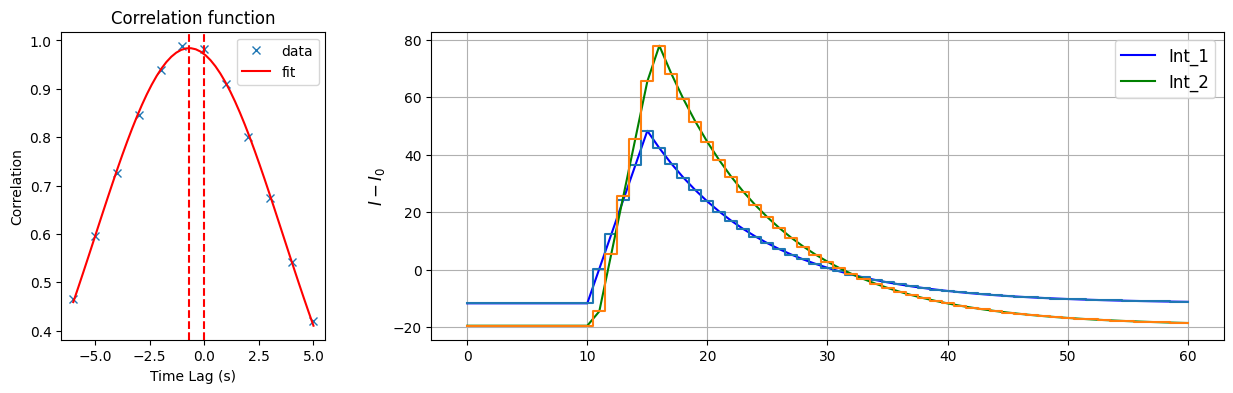

Estimated time lag (max value of the fitting function): -0.69s
Standard deviation error 0.02s
Lag -1.0s


In [26]:
#Using a flare function with a known lag of 0.45s:
#Flare light curve modeled as linear growth followed by a potencial decrese
def flare(x,t0,h,k,a):
    r = []
    for i in range(len(x)):
        if (x[i]<h):
            r_i=(k/(h-t0))*x[i]-k*t0/(h-t0)
            if (r_i>0):
                r.append(r_i)
            else:
                r.append(0)
        else:
            r_i=k*a**((x[i]-h))
            r.append(r_i)
    return r

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#the analysed signals have arround 1min lenght
lt=61#lenght of time series
st=60/(lt-1) #step size in time
na=0 #Noise Amplitude
ns_1=6#Number of seconds to consider un the fit
ns_2=5
ttl=0.75 #theoretical time lag

noise_1 = np.random.uniform(low=-na, high=na, size=(lt))
noise_2 = np.random.uniform(low=-na, high=na, size=(lt))
t=np.linspace(0,60,lt)
Int_1=(flare(t,10,15,100,0.9)+noise_1)*0.6
Int_2=flare(t, 10+ttl,15+ttl,100,0.9)+noise_2

#Correlation function
mean_Int_1=np.mean(Int_1)
mean_Int_2=np.mean(Int_2)
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)

correlation = signal.correlate(Int_1-mean_Int_1, Int_2-mean_Int_2, mode="full")/Norm
lags = signal.correlation_lags(Int_1.size, Int_2.size, mode="full")
lag = lags[np.argmax(correlation)]

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

#Fitting
popt,pcov = curve_fit(gaus,x,y)

#Plot
fig = plt.figure(figsize=(15,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 3], height_ratios=[1])

ax1 = fig.add_subplot(spec[1])

ax1.set_ylabel('Time MM:SS',fontsize=12)
ax1.set_ylabel(r'$I-I_0$',fontsize=12)
ax1.plot(t, Int_1-mean_Int_1, 'b', label='Int_1')
ax1.step(t, Int_1-mean_Int_1, where='mid')
ax1.plot(t, Int_2-mean_Int_2, 'g', label='Int_2')
ax1.step(t, Int_2-mean_Int_2, where='mid')
ax1.grid(True)
ax1.legend(fontsize=12,loc='upper right')

ax2 = fig.add_subplot(spec[0])
ax2.plot(x,y,'x',label='data')
x_ls=(np.linspace(-ns_1, ns_2, num=50))
ax2.plot(x_ls,gaus(x_ls,*popt),'r',label='fit')
ax2.axvline(0, color='r', linestyle='--')
ax2.axvline(popt[1], color='r', linestyle='--')
ax2.legend()
ax2.set_title('Correlation function')
ax2.set_xlabel('Time Lag (s)')
ax2.set_ylabel('Correlation')

plt.show()
print(f"Estimated time lag (max value of the fitting function): {round(popt[1],2)}s")
perr = np.sqrt(np.diag(pcov))
print(f"Standard deviation error {round(perr[1],2)}s")
print(f"Lag {lag*st}s")

In [27]:
def localCCF(x0,y0,k):
    N= len(x0)

    if k>=0:
        x=x0
        y=y0
    else:
        y=x0
        x=y0

    k=abs(k)
    x_ave=(1/(N-k))*np.sum(x[0:N-k])
    y_ave=(1/(N-k))*np.sum(y[(k+1)-1:N])
    c1=np.sum((1/(N-k))*np.square(x[0:N-k]-x_ave))
    c2=np.sum((1/(N-k))*np.square(y[(k+1)-1:N]-y_ave))
    c=0
    for i in range(N-k):
        c=c+((1/(N-k))*(x[i]-x_ave)*(y[i+k]-y_ave))
    ccf= c/(np.sqrt(c1)*np.sqrt(c2))
    return ccf

def TlocalCCF(x0,y0):
    tccf=[]
    k=len(x0)
    for i in range((-k+3),(k-2)):
        tccf.append(localCCF(x0,y0,i))
    return(tccf)

#Note that the way the correlation function is defined here does not match the way the scipy.correlate function is defined with respect to the order of the variables.

#To obtain comparable results, the function TlocalCCF(x,y) should be compared with signal.correlate(y,x)

/tmp/ipython-input-747683650.py:19: RuntimeWarning: invalid value encountered in scalar divide
  ccf= c/(np.sqrt(c1)*np.sqrt(c2))


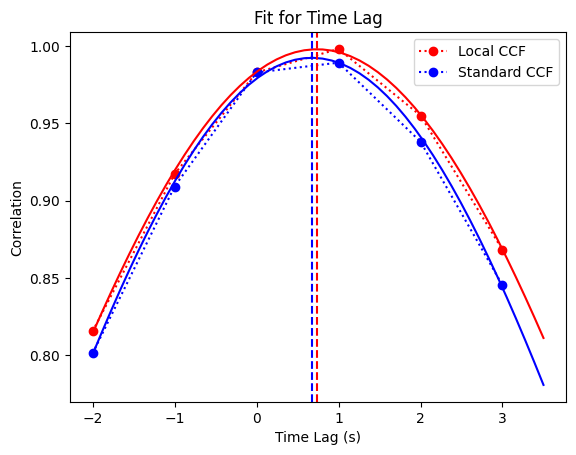

Estimated time lag (max value of the fitting function) using local CCF: 0.74s
Standard deviation error 0.01s
Estimated time lag (max value of the fitting function) using standard CCF: 0.67s
Standard deviation error 0.017s


In [28]:
#The analysed signals have arround 1min lenght
lt=61#lenght of time series
st=60/(lt-1) #step size in time
na=0 #Noise Amplitude
ns_1=4.1#Number of seconds to consider un the fit
ns_2=5.5
ttl=0.75 #theoretical time lag

noise_1 = np.random.uniform(low=-na, high=na, size=(lt))
noise_2 = np.random.uniform(low=-na, high=na, size=(lt))
t=np.linspace(0,60,lt)
Int_1=(flare(t,10,15,100,0.9)+noise_1)*0.6
Int_2=flare(t, 10+ttl,15+ttl,100,0.9)+noise_2

#Correlation function
mean_Int_1=np.mean(Int_1)
mean_Int_2=np.mean(Int_2)
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)

#We try two different cross correlation functions, local CCF and standard CCF
#Local CCF
correlation_1 = TlocalCCF(Int_1,Int_2)
k=len(Int_1)
lags_1 = np.arange(-k+3, k-2, 1) #Len of 95, the lag 0 is at 47

#Standard CCF (used by Paulo)
correlation_2 = signal.correlate(Int_2-mean_Int_2, Int_1-mean_Int_1, mode="full")/Norm
lags_2 = signal.correlation_lags(Int_2.size, Int_1.size, mode="full")

x1=lags_1[56:62]# 58 is the lag equal to zero
y1=correlation_1[56:62] #

x2=lags_2[58:64]# 60is the lag equal to zero
y2=correlation_2[58:64] #


n = len(x1)                          #the number of data
mean = sum(x1*y1)/n
sigma = sum(y1*(x1-mean)**2)/n

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt1,pcov1 = curve_fit(gaus,x1,y1,p0=[1,mean,sigma])
popt2,pcov2 = curve_fit(gaus,x2,y2,p0=[1,mean,sigma])

plt.plot(x1,y1,'ro:',label='Local CCF')
plt.plot(x2,y2,'bo:',label='Standard CCF')
x_ls=np.linspace(-2, 3.5, num=50)
plt.plot(x_ls,gaus(x_ls,*popt1),'r')
plt.plot(x_ls,gaus(x_ls,*popt2),'b')
#plt.axvline(0, color='g', linestyle='--')
plt.axvline(popt1[1], color='r', linestyle='--')
plt.axvline(popt2[1], color='b', linestyle='--')
plt.legend(loc= 'upper right')
plt.title('Fit for Time Lag')
plt.xlabel('Time Lag (s)')
plt.ylabel('Correlation')
plt.show()

print(f"Estimated time lag (max value of the fitting function) using local CCF: {round(popt1[1], 2) }s")
perr = np.sqrt(np.diag(pcov1))
print(f"Standard deviation error {round(perr[1],3)}s")

print(f"Estimated time lag (max value of the fitting function) using standard CCF: {round(popt2[1], 2)}s")
perr = np.sqrt(np.diag(pcov2))
print(f"Standard deviation error {round(perr[1],3)}s")

## Lag estimation using the Cross-correlation (CCF) and Local CCF for a flare signal in mid infrared

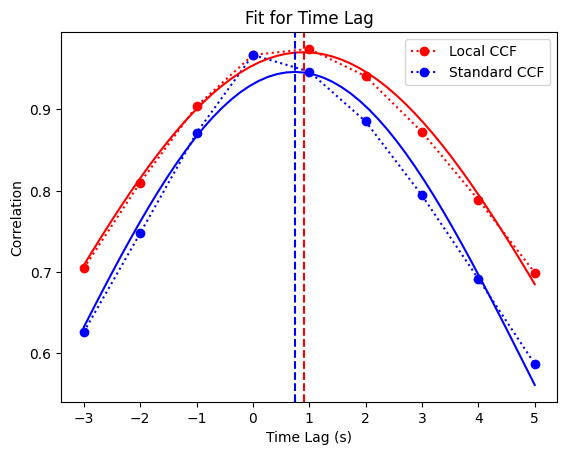

Estimated time lag (max value of the fitting function) using local CCF: 0.9s
Standard deviation error 0.044s
Estimated time lag (max value of the fitting function) using standard CCF: 0.74s
Standard deviation error 0.075s


In [29]:
t1=datetime(2014,9,24,17,49,0) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50, 0) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

#Intended to subtract a vector, for example if necessary subtract the qs value to obtain the relative variations.
subtract= qs_I_10
fA_Isub=np.subtract(fA_I_10,subtract)[p_t1:p_t2]
fB_Isub=np.subtract(fB_I_10,subtract)[p_t1:p_t2]

mean_fA_Isub=np.average(fA_Isub)
mean_fB_Isub=np.average(fB_Isub)

x=fA_Isub-mean_fA_Isub
y=fB_Isub-mean_fB_Isub
Norm=np.std(x)*np.std(y)*len(x)

#We try two different cross correlation functions, local CCF and standard CCF
#Local CCF
correlation_1 = TlocalCCF(y,x)
k=len(x)
lags_1 = np.arange(-k+3, k-2, 1) #Len of 95, the lag 0 is at 47

#Standard CCF (used by Simoes et al 2024)
correlation_2 = signal.correlate(x, y, mode="full")/Norm
lags_2 = signal.correlation_lags(y.size, x.size, mode="full")


x1=lags_1[44:53]# 47 is the lag equal to zero
y1=correlation_1[44:53] #

x2=lags_2[46:55]# 49 is the lag equal to zero
y2=correlation_2[46:55] #


n = len(x)   #the number of data points
mean = sum(x1*y1)/n
sigma = sum(y1*(x1-mean)**2)/n

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

popt1,pcov1 = curve_fit(gaus,x1,y1,p0=[1,mean,sigma])
popt2,pcov2 = curve_fit(gaus,x2,y2,p0=[1,mean,sigma])

plt.plot(x1,y1,'ro:',label='Local CCF')
plt.plot(x2,y2,'bo:',label='Standard CCF')
x_ls=np.linspace(-3, 5, num=50)
plt.plot(x_ls,gaus(x_ls,*popt1),'r')
plt.plot(x_ls,gaus(x_ls,*popt2),'b')
#plt.axvline(0, color='g', linestyle='--')
plt.axvline(popt1[1], color='r', linestyle='--')
plt.axvline(popt2[1], color='b', linestyle='--')
plt.legend(loc= 'upper right')
plt.title('Fit for Time Lag')
plt.xlabel('Time Lag (s)')
plt.ylabel('Correlation')
plt.show()

print(f"Estimated time lag (max value of the fitting function) using local CCF: {round(popt1[1], 2) }s")
perr = np.sqrt(np.diag(pcov1))
print(f"Standard deviation error {round(perr[1],3)}s")

print(f"Estimated time lag (max value of the fitting function) using standard CCF: {round(popt2[1], 2)}s")
perr = np.sqrt(np.diag(pcov2))
print(f"Standard deviation error {round(perr[1],3)}s")

## Time delay between 5.2 and $8.2 \mu \mathrm{~m}$ channels

/tmp/ipython-input-1227265062.py:276: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


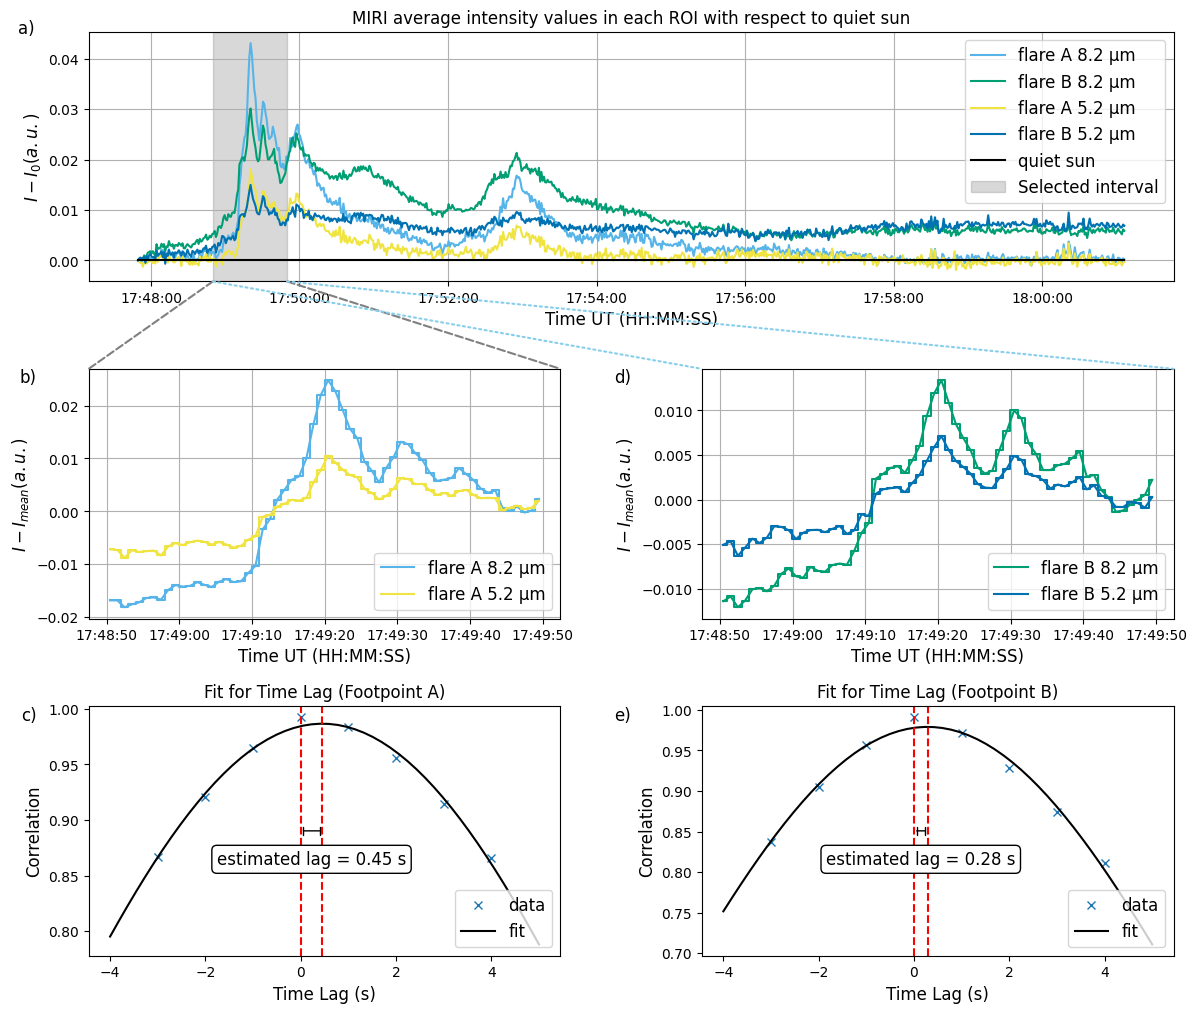

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch


# --- Create figure and 2x3 grid ---
fig = plt.figure(figsize=(14, 12))
spec = gridspec.GridSpec(3, 2, figure=fig, hspace=0.35, wspace=0.3)

# ========== ROW 1 ==========
# Intensity curves with shading
ax1 = fig.add_subplot(spec[0, :])  # spans entire row (colspan=2)

t1=datetime(2014,9,24,17,47,0)
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0]

t2=datetime(2014, 9, 24, 18, 1, 7, 483000)
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0]

t1_s = datetime(2014, 9, 24, 17, 48, 50)
t2_s = datetime(2014, 9, 24, 17, 49, 50)

ax1.set_title('MIRI average intensity values in each ROI with respect to quiet sun')
ax1.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax1.set_ylabel(r'$I-I_0  (a.u.)$', fontsize=12)

ax1.plot(time_10[p_t1:p_t2],
         np.subtract(fA_I_10-fA_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2],
         color=palette[2], label='flare A 8.2 µm')
ax1.plot(time_10[p_t1:p_t2],
         np.subtract(fB_I_10-fB_I_10[0], qs_I_10-qs_I_10[0])[p_t1:p_t2],
         color=palette[3], label='flare B 8.2 µm')

ax1.plot(time_05[p_t1:p_t2],
         np.subtract(fA_I_05-fA_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[4], label='flare A 5.2 µm')
ax1.plot(time_05[p_t1:p_t2],
         np.subtract(fB_I_05-fB_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[5], label='flare B 5.2 µm')

ax1.plot(time_05[p_t1:p_t2],
         np.subtract(qs_I_05-qs_I_05[0], qs_I_05-qs_I_05[0])[p_t1:p_t2],
         color=palette[0], label='quiet sun')

ax1.axvspan(t1_s, t2_s, color='gray', alpha=0.3, label='Selected interval')

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=2))
ax1.tick_params(axis='x', rotation=0)
ax1.grid(True)
ax1.legend(fontsize=12, loc='upper right')

# ========== LEFT COLUMN (FOOTPOINT A) ==========
t1=datetime(2014,9,24,17,48,50) #the initial date of the time series is 2014, 9, 24, 17, 47, 49, 483000
p_t1 = min(enumerate(time_10), key=lambda x: abs(x[1] - t1))[0] #find the position of the closer index given a date

t2=datetime(2014, 9, 24, 17, 49, 50, 0) #the final date of the time series is 2014, 9, 24, 18, 1, 7, 483000
p_t2 = min(enumerate(time_10), key=lambda x: abs(x[1] - t2))[0] #find the position of the closer index given a date

Int_1=np.subtract(fA_I_10-fA_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fA_I_05-fA_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]
t=time_10[p_t1:p_t2]

mean_Int_1=np.average(Int_1)
mean_Int_2=np.average(Int_2)

#Correlation function
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)
ns_1=4#Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds

correlation = TlocalCCF(Int_1, Int_2)

k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

n = len(x)                          #the number of data
mean = sum(x*y)/n
sigma = sum(y*(x-mean)**2)/n
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#Fitting
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

# ====================
# Left column: Intensity curve Flare A
ax4 = fig.add_subplot(spec[1, 0])
ax4.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax4.set_ylabel(r'$I-I_{mean}  (a.u.)$', fontsize=12)
ax4.plot(t, Int_1-mean_Int_1, color=palette[2], label='flare A 8.2 µm')
ax4.step(t, Int_1-mean_Int_1, color=palette[2], where='mid')
ax4.plot(t, Int_2-mean_Int_2, color=palette[4], label='flare A 5.2 µm')
ax4.step(t, Int_2-mean_Int_2, color=palette[4], where='mid')
ax4.grid(True)
ax4.legend(fontsize=12, loc='lower right')

# Left column: Fit point A
ax2 = fig.add_subplot(spec[2, 0])
ax2.plot(x, y, 'x', label='data')
x_ls = np.linspace(-ns_1, ns_2, num=50)
ax2.plot(x_ls, gaus(x_ls, *popt), color=palette[0], label='fit')
ax2.axvline(0, color='r', linestyle='--')
ax2.axvline(popt[1], color='r', linestyle='--')

# Create a bracket (with FancyBracket or FancyArrowPatch bracket style)
bracket = mpatches.FancyArrowPatch(
    (0, 0.5), (popt[1], 0.5),  # initial and final coordinates in X
    transform=ax2.get_xaxis_transform(),  # relative to X axis
    arrowstyle='|-|,widthA=0.2,widthB=0.2',  # bracket style
    mutation_scale=15,  # bracket size
    color="black"
)
ax2.add_patch(bracket)

# Add centered text between the two lines
x_middle = (0 + popt[1]) / 2
ax2.text(
    x_middle, 0.35, f"estimated lag = {popt[1]:.2f} s",
    ha="center", va="bottom",
    transform=ax2.get_xaxis_transform(), fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)
ax2.set_title('Fit for Time Lag (Footpoint A)')
ax2.set_xlabel('Time Lag (s)', fontsize=12)
ax2.set_ylabel('Correlation', fontsize=12)
ax2.legend(fontsize=12, loc='lower right')

# ========== RIGHT COLUMN (FOOTPOINT B) ==========
Int_1=np.subtract(fB_I_10-fB_I_10[0],qs_I_10-qs_I_10[0])[p_t1:p_t2]
Int_2=np.subtract(fB_I_05-fB_I_05[0],qs_I_05-qs_I_05[0])[p_t1:p_t2]
t=time_10[p_t1:p_t2]

mean_Int_1=np.average(Int_1)
mean_Int_2=np.average(Int_2)

#Correlation function
Norm=np.std(Int_1)*np.std(Int_2)*len(Int_1)
ns_1=4 #Number of seconds to consider in the fit
ns_2=5
st=1 #time step size in seconds

correlation = TlocalCCF(Int_1, Int_2)

k=len(Int_1)
lags = np.arange(-k+3, k-2, 1)

x=lags[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]*st
y=correlation[round(len(lags)/2-ns_1/st):round(len(lags)/2+ns_2/st)]

n = len(x)                          #the number of data
mean = sum(x*y)/n
sigma = sum(y*(x-mean)**2)/n

#Fitting
popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

# ====================
# Right column: Intensity curve Flare B
ax3 = fig.add_subplot(spec[1, 1])
ax3.set_xlabel('Time UT (HH:MM:SS)', fontsize=12)
ax3.set_ylabel(r'$I-I_{mean}  (a.u.)$', fontsize=12)
ax3.plot(t, Int_1-mean_Int_1, color=palette[3], label='flare B 8.2 µm')
ax3.step(t, Int_1-mean_Int_1, color=palette[3], where='mid')
ax3.plot(t, Int_2-mean_Int_2, color=palette[5], label='flare B 5.2 µm')
ax3.step(t, Int_2-mean_Int_2, color=palette[5], where='mid')
ax3.grid(True)
ax3.legend(fontsize=12, loc='lower right')

# Right column: Fit point B
ax5 = fig.add_subplot(spec[2, 1])
ax5.plot(x, y, 'x', label='data')
x_ls = np.linspace(-ns_1, ns_2, num=50)
ax5.plot(x_ls, gaus(x_ls, *popt), color=palette[0], label='fit')
ax5.axvline(0, color='r', linestyle='--')
ax5.axvline(popt[1], color='r', linestyle='--')

# Create a bracket (with FancyBracket or FancyArrowPatch bracket style)
bracket = mpatches.FancyArrowPatch(
    (0, 0.5), (popt[1], 0.5),  # initial and final coordinates in X
    transform=ax5.get_xaxis_transform(),  # relative to X axis
    arrowstyle='|-|,widthA=0.2,widthB=0.2',  # bracket style
    mutation_scale=15,  # bracket size
    color="black"
)
ax5.add_patch(bracket)

# Add centered text between the two lines
x_middle = (0 + popt[1]) / 2
ax5.text(
    x_middle, 0.35, f"estimated lag = {popt[1]:.2f} s",
    ha="center", va="bottom",
    transform=ax5.get_xaxis_transform(), fontsize=12,
    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3")
)

ax5.set_title('Fit for Time Lag (Footpoint B)')
ax5.set_xlabel('Time Lag (s)', fontsize=12)
ax5.set_ylabel('Correlation', fontsize=12)
ax5.legend(fontsize=12, loc='lower right')

#---------------Connections ------------------------#

# Origin point in ax1: (t1_s, ymin of ax1)
x0 = mdates.date2num(t1_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax4: top left corner
x1 = ax4.get_xlim()[0]
y1 = ax4.get_ylim()[1]

con1 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax4.transData,
    linestyle="--", color="gray", lw=1.5
)
fig.add_artist(con1)

# Origin point in ax1: (t2_s, ymin of ax1)
x0 = mdates.date2num(t2_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax4: top right corner
x1 = ax4.get_xlim()[1]
y1 = ax4.get_ylim()[1]

con2 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax4.transData,
    linestyle="--", color="gray", lw=1.5
)
fig.add_artist(con2)

# Origin point in ax1: (t2_s, ymin of ax1)
x0 = mdates.date2num(t2_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax3: top right corner
x1 = ax3.get_xlim()[1]
y1 = ax3.get_ylim()[1]

con3 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax3.transData,
    linestyle=":", color="skyblue", lw=1.5
)
fig.add_artist(con3)

# Origin point in ax1: (t1_s, ymin of ax1)
x0 = mdates.date2num(t1_s)
y0 = ax1.get_ylim()[0]
# Destination point in ax3: top left corner
x1 = ax3.get_xlim()[0]
y1 = ax3.get_ylim()[1]

con4 = ConnectionPatch(
    xyA=(x0, y0), coordsA=ax1.transData,
    xyB=(x1, y1), coordsB=ax3.transData,
    linestyle=":", color="skyblue", lw=1.5
)
fig.add_artist(con4)
# ------- Panel labels ------------------------------

ax1.text(-0.05, 1.05, 'a)', transform=ax1.transAxes, fontsize=12, va='top', ha='right')
ax4.text(-0.11, 1.0, 'b)', transform=ax4.transAxes, fontsize=12, va='top', ha='right')
ax2.text(-0.11, 1.0, 'c)', transform=ax2.transAxes, fontsize=12, va='top', ha='right')
ax3.text(-0.15, 1.0, 'd)', transform=ax3.transAxes, fontsize=12, va='top', ha='right')
ax5.text(-0.15, 1.0, 'e)', transform=ax5.transAxes, fontsize=12, va='top', ha='right')

# --- Show ---
plt.tight_layout()
plt.show()

## Infrared emission during a solar flare

### Infrared emission during a solar flare from a RADYN output

In [31]:
#from radynpy.cdf import LazyRadynData
#data = LazyRadynData(r"PathToRADYNOutput")

In [32]:
##This shows the number of time steps (there are 501 time steps in RADYN F-CHROMA outputs)
#times_1=data.time
##proton density for each time and height (there are 300 height steps in RADYN F-CHROMA outputs)
#proton_density=data.n1[:,:,5,0]
##hydrogen density for each time and height
#hydrogen_density=data.n1[:,:,0,0]+data.n1[:,:,1,0]+data.n1[:,:,2,0]+data.n1[:,:,3,0]+data.n1[:,:,4,0]
##Electron density for each time and height
#electron_density=data.ne1
##temperture  for each time and height (es la temperatura de los electrones)
#temperature= data.tg1
##Values of height in cm for each time (data.z1[t,k])
#height_array=data.z1

In [33]:
# Load variables from the pickle file
with open(f'{folder}/RADYN_Outputs_FChromaGrid/radyn_out.val3c_d3_1.0e11_t20s_15kev_fp.pkl', 'rb') as f:
    loaded_data = pickle.load(f)

# variables from the pickle file
times_1 = loaded_data['times_1']
proton_density = loaded_data['proton_density']
hydrogen_density = loaded_data['hydrogen_density']
electron_density = loaded_data['electron_density']
temperature = loaded_data['temperature']
height_array = loaded_data['height_array']

In [34]:
#Functions to calculate K_nu_H, K_nu_H_minus and total_K_nu

# Physical constants (SI and cgs)
#e = const.e # electron charge (1.602176634e-19 C)
e = 4.803250e-10 #ESU
#m = const.m_e # electron mass (9.10938356e-31 Kg)
m = 9.109558e-28 #g
#h = const.h # PlancK's constant (6.62607015e-34 J s)
h = 6.62607015e-27 #erg s
#c = const.c # speed of light (299792458 m/s)
c = 29979245800 #cm/s
#Kb = const.K # Boltzmann constant (1.380649e-23 J/K)
Kb = 1.380649e-16 #erg K-1
pi = const.pi # π (3.141592653589793)
cte = ((4*e**6)/(3*m*h*c)) * ((2*pi)/(3*Kb*m))**0.5
cte = (3.7e8)
def K_nu_H(T,n_e, n_p,nu):
    """
    Calculate the absorption coefficient for H

    Parameters:
    T (float): temperature [K]
    n_e (float): electron density [cm^-3]
    n_p (float): proton density [cm^-3]
    nu (float): frequency [Hz]

    Returns:
    float: absorption coefficient K_nu(H-) [cm^-1]
    """
    g_ff=1 #Gaunt factor

    K_nu_H=(cte)*T**(-1/2)*n_e*n_p*nu**(-3)*g_ff
    return K_nu_H

def K_nu_H_minus(n_e, n_H, nu, T):
    """
    Calculate the absorption coefficient for H-

    Parameters:
    n_e: electron density [cm^-3]
    n_H: neutral hydrogen density [cm^-3]
    nu: frequency [Hz]
    T : temperature [K]

    Returns:
    float: absorption coefficient K_nu(H-) [cm^-1]
    """
    A1 = 1.3727e-25 #units?
    A2 = 4.3748e-10 #units?
    A3 = 2.5993e-7  #units?

    K_nu_H_minus = (n_e*n_H/nu) * (A1+ ((A2-A3/T)/nu))
    return K_nu_H_minus


def total_K_nu(K_nu_H, K_nu_H_minus, nu, T):
    """
    Calculate the total absorption coefficient including stimulated emission correction.

    Parameters:
    K_nu_H: absorption coefficient from neutral hydrogen [cm^-1]
    K_nu_H_minus: absorption coefficient from H- [cm^-1]
    nu: frequency [Hz]
    T: temperature [K]

    Returns:
    float: total absorption coefficient with stimulated emission correction [cm^-1]
    """

    # Stimulated emission correction term
    stimulated_emission_correction = 1 - np.exp((-h*nu)/(Kb*T))

    # Total absorption coefficient
    total_K_nu = (K_nu_H + K_nu_H_minus)*stimulated_emission_correction

    return total_K_nu

def total_K_nu_H_minus(K_nu_H_minus, nu, T):
    """
    Calculate the total absorption coefficient for H minus including stimulated emission correction.

    Parameters:
    K_nu_H_minus: absorption coefficient from H- [cm^-1]
    nu: frequency [Hz]
    T: temperature [K]

    Returns:
    float: total absorption coefficient with stimulated emission correction [cm^-1]
    """

    # Stimulated emission correction term
    stimulated_emission_correction = 1 - np.exp((-h*nu)/(Kb*T))

    # Total absorption coefficient
    total_K_nu = (K_nu_H_minus)*stimulated_emission_correction

    return total_K_nu

def total_K_nu_H(K_nu_H, nu, T):
    """
    Calculate the total absorption coefficient for H including stimulated emission correction.

    Parameters:
    K_nu_H: absorption coefficient from neutral hydrogen [cm^-1]
    nu: frequency [Hz]
    T: temperature [K]

    Returns:
    float: total absorption coefficient with stimulated emission correction [cm^-1]
    """

    # Stimulated emission correction term
    stimulated_emission_correction = 1 - np.exp((-h*nu)/(Kb*T))

    # Total absorption coefficient
    total_K_nu = (K_nu_H)*stimulated_emission_correction

    return total_K_nu


def B_nu(nu, T):
    """
    Calculate the spectral radiance of a blacKbody using PlancK's law.

    Parameters:
    nu: Frequency [Hz]
    T : Temperature [K]

    Returns:
    Spectral radiance [W·sr^-1·m^-2·Hz^-1] or in cgs [erg^-1 sr^-1 cm^-2 Hz^-1]
    """

    B_nu = (2*h*nu**3/c**2)/(np.exp((h*nu)/(Kb*T)) - 1)

    return B_nu

def tau_nu(K_nu_array, height_array, i_s0):
    """
    Calculate optical depth from a position s to a height s0 = 10Mm (where the observer is located),
    In RADYN we asume the observer is at 10Mm, and there are 300 steps between 0Mm and 10Mm.
    The integral is estimated as the discrete sum of all the K_nu(s)*ds terms added.

    Parameters:
    K_nu_array: Total absorption coefficient array (K_nu at each position between 0 and 10Mm)
    i_s0 : index of the height at which the optical depth is calculated, It has to be between 0 and 299.

    Returns:
    Optical depth in a given position s [units?]
    """
    tau_nu=0
    ds = np.diff(height_array)               # delta h_i = h_{i+1} - h_i
    K_nu_array_left = K_nu_array[:-1]              # use left values for the Riemann sum
    tau_nu = np.sum(K_nu_array_left[0:i_s0] * ds[0:i_s0])        # sum_i CF(h_i) * delta_h_i
    tau_nu= -tau_nu

    return tau_nu

def tau_nu2(K_nu_array, height_array, i_s0):
    """
    Calculate optical depth from a position s to a height s0 = 10Mm (where the observer is located),
    In RADYN we asume the observer is at 10Mm, and there are 300 steps between 0Mm and 10Mm.

    Parameters:
    K_nu_array: Total absorption coefficient array (K_nu at each position between 0 and 10Mm)
    i_s0 : index of the height at which the optical depth is calculated, It has to be between 0 and 299.

    Returns:
    Optical depth in a given position s [units?]
    """
    tau_nu=0
    tau_nu = integrate.trapezoid(K_nu_array[0:(i_s0)],x=height_array[0:(i_s0)]) # For a better approximation, the trapezoidal approximation of the integral is used here.
    tau_nu= -tau_nu
    return tau_nu

def CF(K_nu, B_nu, tau_nu):
    """
    Calculate the contribution function at a position "s" that is determined by the value of tau_nu given to it.

    Parameters:
    K_nu: Total absorption coefficient at each s. [cm-1]
    B_nu: Spectral radiance of a blacKbody using PlancK's law [erg^-1 sr^-1 cm^-2 Hz^-1] at each s.
    tau_nu: Optical depth at each s.

    Returns:
    Contribution function at a position each "s" [erg^-1 sr^-1 cm^-3 Hz^-1]
    """

    j_nu= K_nu*B_nu
    CF=j_nu*np.exp(-1*np.array(tau_nu))

    return CF

def Intensity(CF_nu_array, height_array):
    """
    Calculate the intensity using a left Riemann sum.

    Parameters:
    CF_nu_array: Array of contribution function values (same shape as height_array)
    height_array: Array of heights (in cm), not necessarily uniform, 300 values from 0 to 10 Mm

    Returns:
    Integrated intensity over height (in [units of CF_nu * cm])
    """
    ds = np.diff(height_array)              # delta h_i = h_{i+1} - h_i
    CF_left = CF_nu_array[:-1]              # use left values for the Riemann sum
    intensity = np.sum(CF_left * ds)        # sum_i CF(h_i) * delta_h_i
    intensity = -intensity
    return intensity

def Intensity2(CF_nu_array, height_array):
    """
    Calculate the intensity.
    In RADYN we assume the observer is at 10Mm, and there are 300 steps between 0Mm and 10Mm.
    The integral is estimated as the discrete sum (using the trapezoidal rule) of all the CF(s)*ds terms.

    Parameters:
    CF_nu_array: Array of contribution function values (same shape as height_array)
    height_array: Array of heights (in cm), not necessarily uniform, 300 values from 0 to 10 Mm

    Returns:
    Integrated intensity over height (in [units of CF_nu * cm])
    """
    return  -integrate.trapezoid(CF_nu_array, x=height_array)


def T_b(nu, Iv):
    """
    Calculates the brightness temperature T_b(nu) from the spectral intensity Iv and frequency nu.

    Parameters:
    nu : float
        Frequency in Hz.
    Iv : float
        Spectral intensity in [erg^-1 sr^-1 cm^-2 Hz^-1] or [W·m⁻²·Hz⁻¹·sr⁻¹].

    Returns:
    float
        Brightness temperature T_b in Kelvins (K).
    """
    nu = np.asarray(nu, dtype=float)
    Iv = np.asarray(Iv, dtype=float)

    Tb = (c**2 / (2 * Kb * nu**2)) * Iv
    return Tb


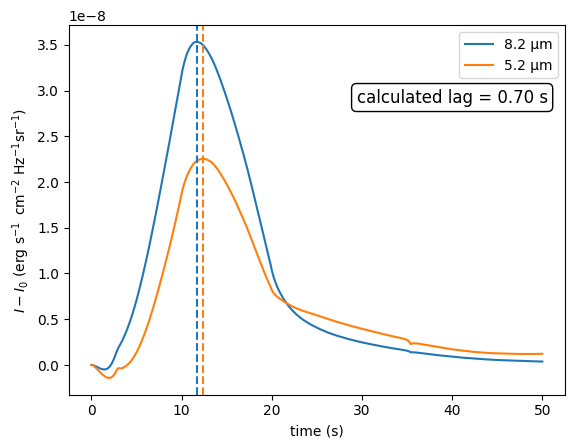

Initial intensity 8μm: 2.057776310557577e-06 (erg*s^-1*cm^-2*Hz^-1*sr^-1)
Initial intensity 5μm: 4.922201980210305e-06 (erg*s^-1*cm^-2*Hz^-1*sr^-1)
time max intesnity 8um: 11.70s
time max intesnity 5um: 12.40s
Delay between max: 0.70s


In [35]:
#Variation of intensity in time

I_5um=[]
I_8um=[]

#time steps (goes from 0 to 501)
for n in range(501):
    N_puntos= 10000

    height_array_n = height_array[n, :]-np.min(height_array[n, :])
    height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)

    # Parameters for each point in time (n) and space (i) taKen from RADYN
    n_e = electron_density[n, :]
    n_p = proton_density[n, :]
    n_H = hydrogen_density[n, :]
    T = temperature[n, :]

    #5um:
    nu = 5.765e+13  # frequency in Hz
    K_5um_H_values = K_nu_H(T, n_e, n_p, nu)
    K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)
    K_5um_values = total_K_nu(K_5um_H_values, K_5um_H_minus_values, nu, T)
    K_5um_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_values)[::-1])[::-1])
    T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

    B_5um = B_nu(nu, T2)
    j_5um = K_5um_values*B_5um

    #FIRST INTGRATION
    tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)
    CF_5um= CF(K_5um_values, B_5um, tau_5um)

    #SECOND INTEGRATION
    I_5um_n = -integrate.trapezoid(CF_5um, x=height_array_inter)
    I_5um.append(I_5um_n)

    #8um:
    nu = 3.656e+13  # frequency
    K_8um_H_values = K_nu_H(T, n_e, n_p, nu)
    K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)
    K_8um_values = total_K_nu(K_8um_H_values, K_8um_H_minus_values, nu, T)
    K_8um_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_values)[::-1])[::-1])

    B_8um = B_nu(nu, T2)
    j_8um = K_8um_values*B_8um

    #FIRST INTGRATION
    tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)
    CF_8um= CF(K_8um_values, B_8um, tau_8um)

    #SECOND INTEGRATION
    I_8um_n =  -integrate.trapezoid(CF_8um, x=height_array_inter)
    I_8um.append(I_8um_n)

T_5um = T_b(5.765e+13, I_5um)
T_8um = T_b(3.656e+13, I_8um)

#PLOT
plt.plot(times_1,(I_8um-I_8um[0]), label="8.2 µm", color='C0')
plt.plot(times_1,(I_5um-I_5um[0]), label="5.2 µm", color='C1')
max_height_8um = times_1[np.argmax(I_8um)]
max_height_5um = times_1[np.argmax(I_5um)]
delay_max= max_height_5um-max_height_8um
plt.axvline(x = max_height_8um,color='C0',linestyle='--')
plt.axvline(x = max_height_5um,color='C1',linestyle='--')
plt.xlabel('time (s)')
plt.ylabel(r"$I - I_{0}$ ($\operatorname{erg~s}^{-1} \mathrm{~cm}^{-2} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)")
plt.legend()

plt.text(max(times_1)*0.8, max(I_8um-I_8um[0])*0.8,
         f"calculated lag = {delay_max:.2f} s",
         ha="center", va="bottom", fontsize=12,
         bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

plt.show()

#PRINTS
delay_max= max_height_5um-max_height_8um
print(f"Initial intensity 8μm: {I_8um[0]} (erg*s^{-1}*cm^{-2}*Hz^{-1}*sr^{-1})")
print(f"Initial intensity 5μm: {I_5um[0]} (erg*s^{-1}*cm^{-2}*Hz^{-1}*sr^{-1})")
print(f"time max intesnity 8um: {max_height_8um:.2f}s")
print(f"time max intesnity 5um: {max_height_5um:.2f}s")
print(f"Delay between max: {delay_max:.2f}s")

<>:96: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-3515021856.py:96: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('CF ($\mathrm{erg~s}^{-1} \mathrm{~cm}^{-3} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)')


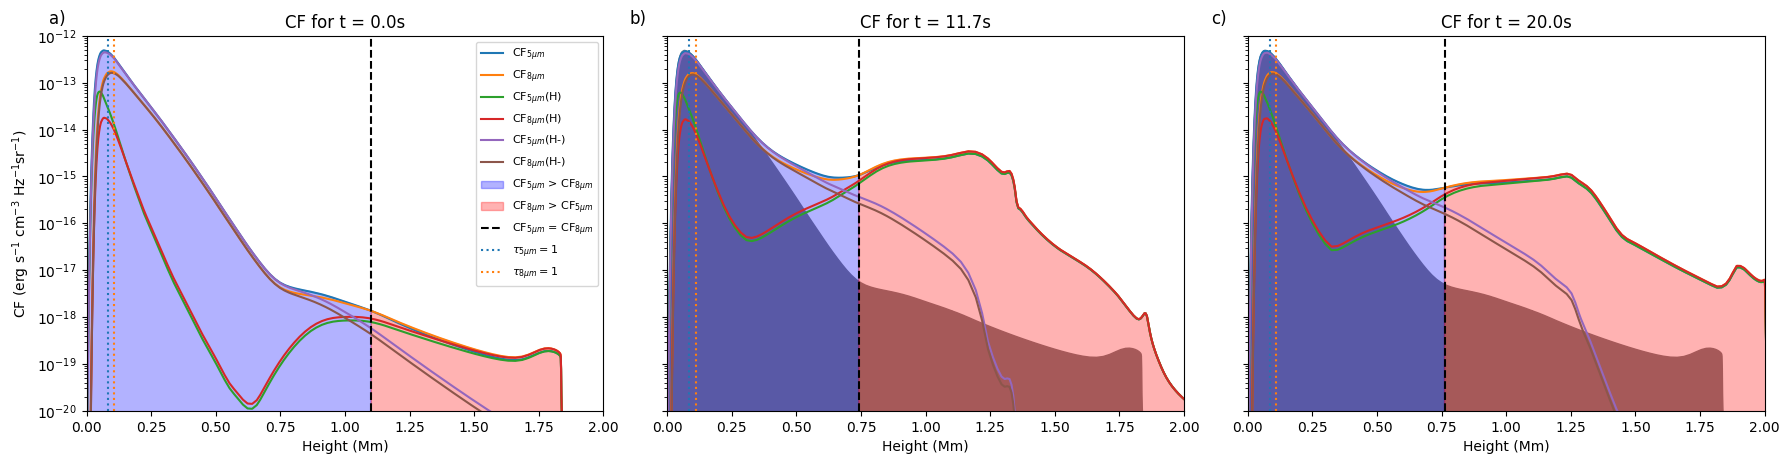

In [36]:
N_puntos = 10000
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# ===============================
# Panel 1: t = 0s (n=0)
# ===============================
n=0
#For each time step (n)
height_array_n = height_array[n, :]-np.min(height_array[n, :])
height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)

# Parameters for each point in time (n) and space (i) taKen from RADYN
n_e = electron_density[n, :]
n_p = proton_density[n, :]
n_H = hydrogen_density[n, :]
T = temperature[n, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
K_5um_values = K_5um_H_values + K_5um_H_minus_values
T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

B_5um = B_nu(nu, T2)
j_5um = K_5um_values*B_5um

tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
CF_5um = CF(K_5um_values, B_5um, tau_5um)

I_5um_n = Intensity2(CF_5um,height_array_inter)

#8um:
nu = 3.656e+13  # frequency
ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
K_8um_values = K_8um_H_values + K_8um_H_minus_values

B_8um = B_nu(nu, T2)
j_8um = K_8um_values*B_8um

tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
CF_8um= CF(K_8um_values, B_8um, tau_8um)

I_8um_n = Intensity2(CF_8um,height_array_inter)


# ---- Plot ----
ax = axes[0]
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF$_{5μm}$", color='C0' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF$_{8μm}$", color='C1' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label=r"CF$_{5μm}$(H)", color='C2' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label=r"CF$_{8μm}$(H)", color='C3' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label=r"CF$_{5μm}$(H-)", color='C4' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label=r"CF$_{8μm}$(H-)", color='C5' )

# Region where CF_5um > CF_8um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=(CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label=r"CF$_{5μm}$ > CF$_{8μm}$")
# Region where CF_8um > CF_5um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label=r"CF$_{8μm}$ > CF$_{5μm}$")

# Index where difference change sign
cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

# vertical doted line
ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label=r'CF$_{5μm}$ = CF$_{8μm}$')

  # === Líneas verticales donde tau = 1 ===
# Buscar índice más cercano a tau = 1 para 5um
if np.any(tau_5um >= 1):
  idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau_{5\mu m}=1$')

# Buscar índice más cercano a tau = 1 para 8um
if np.any(tau_8um >= 1):
  idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau_{8\mu m}=1$')


ax.set_title(f'CF for t = {n*0.1:.1f}s')
ax.set_xlabel('Height (Mm)')
ax.set_ylabel('CF ($\mathrm{erg~s}^{-1} \mathrm{~cm}^{-3} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)')
ax.set_yscale('log')
ax.set_ylim(1e-20, 1e-12)
ax.set_xlim(0,2)
ax.legend(fontsize=10,loc='upper right')
ax.text(-0.04, 1.07, "a)", transform=ax.transAxes, fontsize=12, va='top', ha='right')

# ===============================
# Panel 2: t = 3s (n=30)
# ===============================
n = 117
height_array_0 = height_array[0, :]-np.min(height_array[0, :])
height_array_inter_0=np.linspace(np.max(height_array_0), 0, N_puntos)

# Parameters for each point in time (n=0) and space (i) taKen from RADYN
n_e_0 = electron_density[0, :]
n_p_0 = proton_density[0, :]
n_H_0 = hydrogen_density[0, :]
T_0 = temperature[0, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_5um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_5um_0
K_5um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_values_0)[::-1])[::-1])
K_5um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_5um_0
K_5um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_minus_values_0)[::-1])[::-1])
K_5um_values_0 = K_5um_H_values_0 + K_5um_H_minus_values_0
T2_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(T_0)[::-1])[::-1])

B_5um_0 = B_nu(nu, T2_0)
j_5um_0 = K_5um_values_0*B_5um_0

tau_5um_0 = -integrate.cumulative_trapezoid(K_5um_values_0, x=height_array_inter_0, initial=0)

CF_5um_H_0 = CF(K_5um_H_values_0, B_5um_0, tau_5um_0)
CF_5um_H_minus_0 = CF(K_5um_H_minus_values_0, B_5um_0, tau_5um_0)
CF_5um_0 = CF(K_5um_values_0, B_5um_0, tau_5um_0)

#8um:
nu = 3.656e+13  # frequency
ec_8um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_8um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_8um_0
K_8um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_values_0)[::-1])[::-1])
K_8um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_8um_0
K_8um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_minus_values_0)[::-1])[::-1])
K_8um_values_0 = K_8um_H_values_0 + K_8um_H_minus_values_0

B_8um_0 = B_nu(nu, T2_0)
j_8um_0 = K_8um_values_0*B_8um_0

tau_8um_0 = -integrate.cumulative_trapezoid(K_8um_values_0, x=height_array_inter_0, initial=0)

CF_8um_H_0 = CF(K_8um_H_values_0, B_8um_0, tau_8um_0)
CF_8um_H_minus_0 = CF(K_8um_H_minus_values_0, B_8um_0, tau_8um_0)
CF_8um_0= CF(K_8um_values_0, B_8um_0, tau_8um_0)


#For each time step (n)
height_array_n = height_array[n, :]-np.min(height_array[n, :])
height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)
#height_array_inter=height_array_n

# Parameters for each point in time (n) and space (i) taKen from RADYN
n_e = electron_density[n, :]
n_p = proton_density[n, :]
n_H = hydrogen_density[n, :]
T = temperature[n, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
K_5um_values = K_5um_H_values + K_5um_H_minus_values
T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

B_5um = B_nu(nu, T2)
j_5um = K_5um_values*B_5um

tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
CF_5um = CF(K_5um_values, B_5um, tau_5um)

#8um:
nu = 3.656e+13  # frequency
ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
K_8um_values = K_8um_H_values + K_8um_H_minus_values

B_8um = B_nu(nu, T2)
j_8um = K_8um_values*B_8um

tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
CF_8um= CF(K_8um_values, B_8um, tau_8um)

I_8um_n = Intensity2(CF_8um,height_array_inter)

# ... PLOT ....#
ax = axes[1]
# Region where CF_5um_0 > CF_8um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_5um_0[0:N_puntos], 0, where=( CF_5um_0[0:N_puntos] > CF_8um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)
# Region where CF_8um_0 > CF_5um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_8um_0[0:N_puntos], 0, where=(CF_8um_0[0:N_puntos] >  CF_5um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF$_{5μm}$", color='C0' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF$_{8μm}$", color='C1' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label=r"CF$_{5μm}$(H)", color='C2' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label=r"CF$_{8μm}$(H)", color='C3' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label=r"CF$_{5μm}$(H-)", color='C4' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label=r"CF$_{8μm}$(H-)", color='C5' )

# Region where CF_5um > CF_8um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=(CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label=r"CF$_{5μm}$ > CF$_{8μm}$")
# Region where CF_8um > CF_5um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label=r"CF$_{8μm}$ > CF$_{5μm}$")

# Index where difference change sign
cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

# vertical doted line
ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label=r'CF$_{5μm}$ = CF$_{8μm}$')

  # === Líneas verticales donde tau = 1 ===
# Buscar índice más cercano a tau = 1 para 5um
if np.any(tau_5um >= 1):
  idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau_{5\mu m}=1$')

# Buscar índice más cercano a tau = 1 para 8um
if np.any(tau_8um >= 1):
  idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau_{8\mu m}=1$')


ax.set_title(f'CF for t = {n*0.1:.1f}s')
ax.set_xlabel('Height (Mm)')
ax.set_yscale('log')
ax.set_ylim(1e-20, 1e-12)
ax.set_xlim(0,2)
# Etiqueta tipo panel
ax.text(-0.04, 1.07, "b)", transform=ax.transAxes, fontsize=12, va='top', ha='right')

# ===============================
# Panel 3: t = 10s (n=100)
# ===============================
n = 200
height_array_0 = height_array[0, :]-np.min(height_array[0, :])
height_array_inter_0=np.linspace(np.max(height_array_0), 0, N_puntos)

# Parameters for each point in time (n=0) and space (i) taKen from RADYN
n_e_0 = electron_density[0, :]
n_p_0 = proton_density[0, :]
n_H_0 = hydrogen_density[0, :]
T_0 = temperature[0, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_5um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_5um_0
K_5um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_values_0)[::-1])[::-1])
K_5um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_5um_0
K_5um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_5um_H_minus_values_0)[::-1])[::-1])
K_5um_values_0 = K_5um_H_values_0 + K_5um_H_minus_values_0
T2_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(T_0)[::-1])[::-1])

B_5um_0 = B_nu(nu, T2_0)
j_5um_0 = K_5um_values_0*B_5um_0

tau_5um_0 = -integrate.cumulative_trapezoid(K_5um_values_0, x=height_array_inter_0, initial=0)

CF_5um_H_0 = CF(K_5um_H_values_0, B_5um_0, tau_5um_0)
CF_5um_H_minus_0 = CF(K_5um_H_minus_values_0, B_5um_0, tau_5um_0)
CF_5um_0 = CF(K_5um_values_0, B_5um_0, tau_5um_0)

#8um:
nu = 3.656e+13  # frequency
ec_8um_0=(1 - np.exp((-h*nu)/(Kb*T_0)))
K_8um_H_values_0 = K_nu_H(T_0, n_e_0, n_p_0, nu)*ec_8um_0
K_8um_H_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_values_0)[::-1])[::-1])
K_8um_H_minus_values_0 = K_nu_H_minus(n_e_0, n_H_0, nu, T_0)*ec_8um_0
K_8um_H_minus_values_0 = np.exp(np.interp(height_array_inter_0[::-1], height_array_0[::-1], np.log(K_8um_H_minus_values_0)[::-1])[::-1])
K_8um_values_0 = K_8um_H_values_0 + K_8um_H_minus_values_0

B_8um_0 = B_nu(nu, T2_0)
j_8um_0 = K_8um_values_0*B_8um_0

tau_8um_0 = -integrate.cumulative_trapezoid(K_8um_values_0, x=height_array_inter_0, initial=0)

CF_8um_H_0 = CF(K_8um_H_values_0, B_8um_0, tau_8um_0)
CF_8um_H_minus_0 = CF(K_8um_H_minus_values_0, B_8um_0, tau_8um_0)
CF_8um_0= CF(K_8um_values_0, B_8um_0, tau_8um_0)

#For each time step (n)
height_array_n = height_array[n, :]-np.min(height_array[n, :])
height_array_inter=np.linspace(np.max(height_array_n), 0, N_puntos)


# Parameters for each point in time (n) and space (i) taKen from RADYN
n_e = electron_density[n, :]
n_p = proton_density[n, :]
n_H = hydrogen_density[n, :]
T = temperature[n, :]

#5um:
nu = 5.765e+13  # frequency in Hz
ec_5um=(1 - np.exp((-h*nu)/(Kb*T)))
K_5um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_5um
K_5um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_values)[::-1])[::-1])
K_5um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_5um
K_5um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_5um_H_minus_values)[::-1])[::-1])
K_5um_values = K_5um_H_values + K_5um_H_minus_values
T2 = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(T)[::-1])[::-1])

B_5um = B_nu(nu, T2)
j_5um = K_5um_values*B_5um

tau_5um = -integrate.cumulative_trapezoid(K_5um_values, x=height_array_inter, initial=0)

CF_5um_H = CF(K_5um_H_values, B_5um, tau_5um)
CF_5um_H_minus = CF(K_5um_H_minus_values, B_5um, tau_5um)
CF_5um = CF(K_5um_values, B_5um, tau_5um)

I_5um_n = Intensity2(CF_5um,height_array_inter)

#8um:
nu = 3.656e+13  # frequency in Hz
ec_8um=(1 - np.exp((-h*nu)/(Kb*T)))
K_8um_H_values = K_nu_H(T, n_e, n_p, nu)*ec_8um
K_8um_H_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_values)[::-1])[::-1])
K_8um_H_minus_values = K_nu_H_minus(n_e, n_H, nu, T)*ec_8um
K_8um_H_minus_values = np.exp(np.interp(height_array_inter[::-1], height_array_n[::-1], np.log(K_8um_H_minus_values)[::-1])[::-1])
K_8um_values = K_8um_H_values + K_8um_H_minus_values

B_8um = B_nu(nu, T2)
j_8um = K_8um_values*B_8um

tau_8um = -integrate.cumulative_trapezoid(K_8um_values, x=height_array_inter, initial=0)

CF_8um_H = CF(K_8um_H_values, B_8um, tau_8um)
CF_8um_H_minus = CF(K_8um_H_minus_values, B_8um, tau_8um)
CF_8um= CF(K_8um_values, B_8um, tau_8um)

I_8um_n = Intensity2(CF_8um,height_array_inter)

# ... PLOT ....#
ax = axes[2]
# Region where CF_5um_0 > CF_8um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_5um_0[0:N_puntos], 0, where=( CF_5um_0[0:N_puntos] > CF_8um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)
# Region where CF_8um_0 > CF_5um_0
ax.fill_between(height_array_inter_0[0:N_puntos] / 1e8 , CF_8um_0[0:N_puntos], 0, where=(CF_8um_0[0:N_puntos] >  CF_5um_0[0:N_puntos]), interpolate=True, color='grey', alpha=1)

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um[0:N_puntos],label="CF$_{5μm}$", color='C0' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um[0:N_puntos],label="CF$_{8μm}$", color='C1' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H[0:N_puntos],label=r"CF$_{5μm}$(H)", color='C2' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H[0:N_puntos],label=r"CF$_{8μm}$(H)", color='C3' )

ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_5um_H_minus[0:N_puntos],label=r"CF$_{5μm}$(H-)", color='C4' )
ax.plot(height_array_inter[0:N_puntos]/(1e8), CF_8um_H_minus[0:N_puntos],label=r"CF$_{8μm}$(H-)", color='C5' )

# Region where CF_5um > CF_8um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_5um[0:N_puntos], 0, where=(CF_5um[0:N_puntos] > CF_8um[0:N_puntos]), interpolate=True, color='blue', alpha=0.3, label=r"CF$_{5μm}$ > CF$_{8μm}$")
# Region where CF_8um > CF_5um
ax.fill_between(height_array_inter[0:N_puntos] / 1e8 , CF_8um[0:N_puntos], 0, where=(CF_8um[0:N_puntos] >  CF_5um[0:N_puntos]), interpolate=True, color='red', alpha=0.3, label=r"CF$_{8μm}$ > CF$_{5μm}$")

# Index where difference change sign
cross_index = np.where(np.diff(np.sign(CF_5um - CF_8um)))[0][0]

# vertical doted line
ax.axvline(height_array_inter[cross_index]/1e8, color='k', linestyle='--', label=r'CF$_{5μm}$ = CF$_{8μm}$')

  # === Líneas verticales donde tau = 1 ===
# Buscar índice más cercano a tau = 1 para 5um
if np.any(tau_5um >= 1):
  idx_tau1_5um = np.where(tau_5um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_5um]/1e8, color='C0', linestyle=':', label=r'$\tau_{5\mu m}=1$')

# Buscar índice más cercano a tau = 1 para 8um
if np.any(tau_8um >= 1):
  idx_tau1_8um = np.where(tau_8um >= 1)[0][0]
  ax.axvline(height_array_inter[idx_tau1_8um]/1e8, color='C1', linestyle=':', label=r'$\tau_{8\mu m}=1$')


ax.set_title(f'CF for t = {n*0.1:.1f}s')
ax.set_xlabel('Height (Mm)')
ax.set_yscale('log')
ax.set_ylim(1e-20, 1e-12)
ax.set_xlim(0,2)
ax.text(-0.04, 1.07, "c)", transform=ax.transAxes, fontsize=12, va='top', ha='right')
# ===============================
# General
# ===============================
axes[0].legend(fontsize=8, loc="upper right")

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(r"C:\Users\migue\OneDrive - University of Glasgow\IR\img_paper_1\CFs.png", format="png", dpi=300)

plt.show()

### Different RADYN scenarios

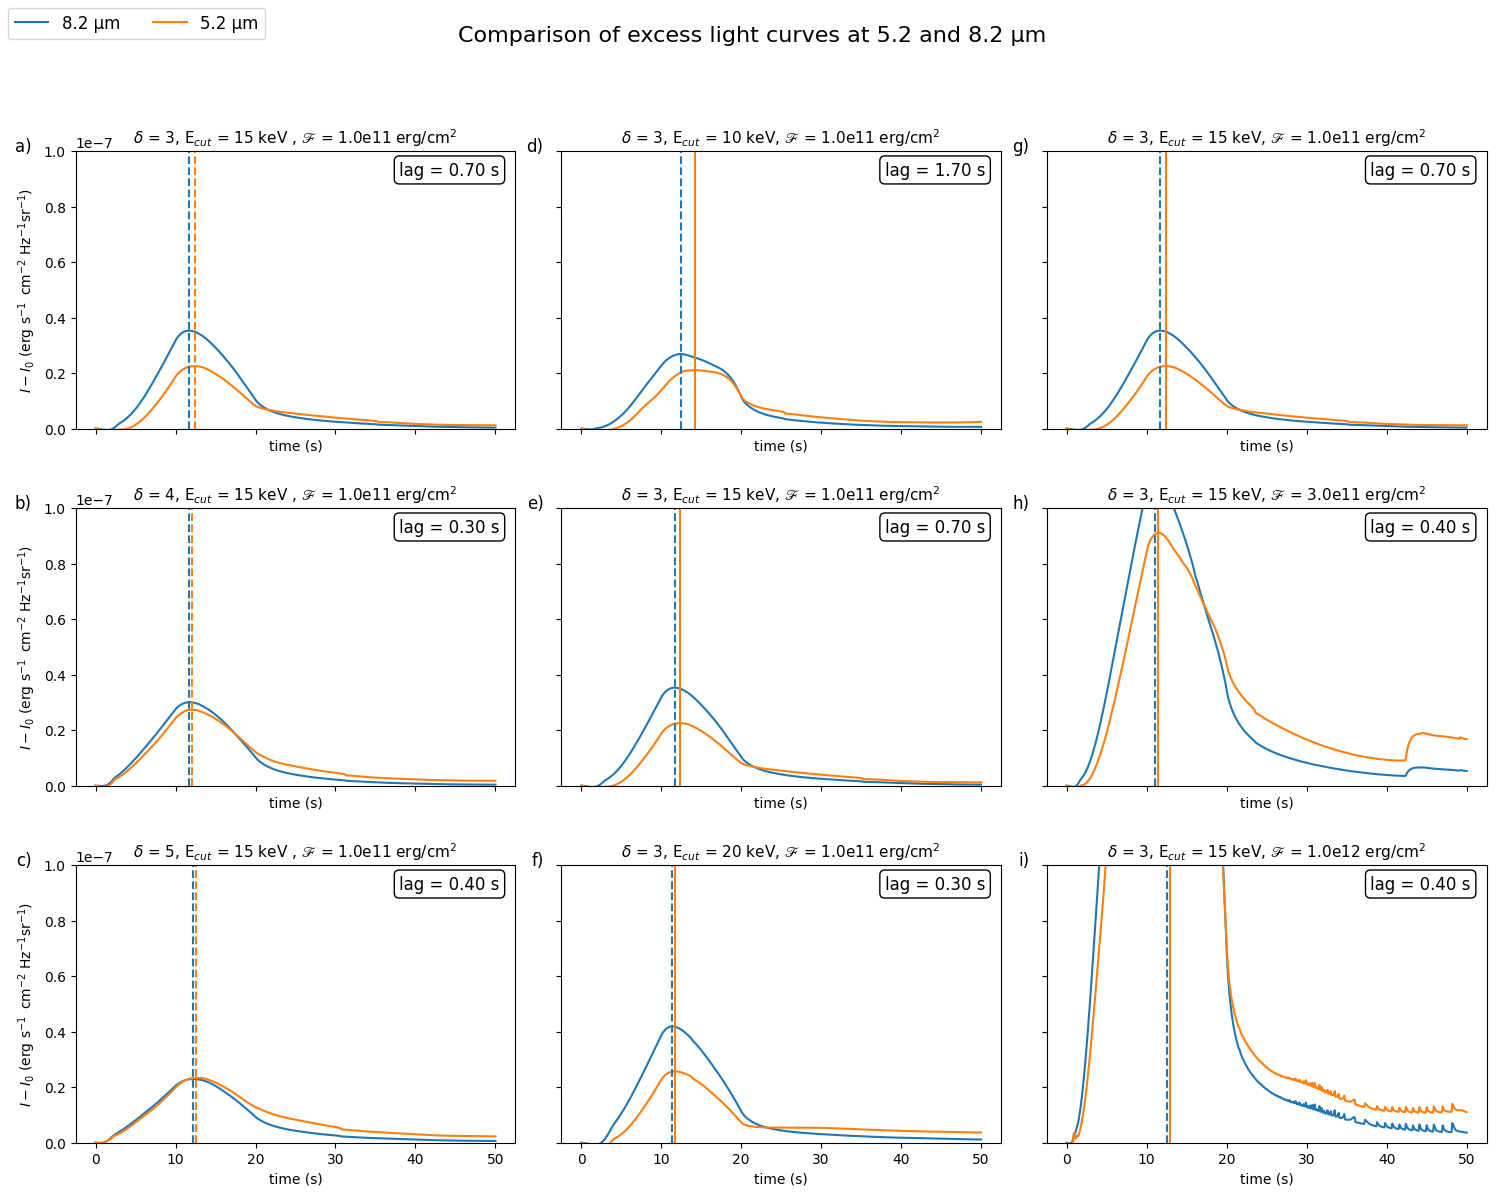

In [37]:
# Folder where .pkl files are located
input_folder = f"{folder}/RADYN_Outputs_FChromaGrid"

def load_data(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)

# 3x3 figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)

# Panel labels: a) - i), by columns
panel_labels = ['a)', 'b)','c)', 'd)','e)','f)','g)','h)','i)']
label_idx = 0  # index to assign letters

# ---------------------------------------------------
# Column 1: vary spectral index (d3, d4, d5)
indices = [3, 4, 5]
j = 0  # column 0
for i, d in enumerate(indices):
    filename = f"radyn_out.val3c_d{d}_1.0e11_t20s_15kev_fp.pkl"
    data = load_data(os.path.join(input_folder, filename))
    times = data["times_1"]
    I5, I8 = data["I_5um"], data["I_8um"]

    ax = axes[i, j]

    # Panel label
    ax.text(-0.1, 1.05, panel_labels[label_idx], transform=ax.transAxes,
            fontsize=12, va='top', ha='right')
    label_idx += 1

    ax.plot(times, (I8 - I8[0]), color='C0', label="8.2 µm")
    ax.plot(times, (I5 - I5[0]), color='C1', label="5.2 µm")

    max_t8 = times[np.argmax(I8)]
    max_t5 = times[np.argmax(I5)]
    ax.axvline(x=max_t8, color='C0', linestyle='--')
    ax.axvline(x=max_t5, color='C1', linestyle='--')

    ax.set_xlabel("time (s)")
    ax.set_ylabel(r"$I - I_{0}$ ($\operatorname{erg~s}^{-1} \mathrm{~cm}^{-2} \mathrm{~Hz}^{-1} \mathrm{sr}^{-1}$)")
    ax.set_ylim(0, 13e-08)

    delay_max = max_t5 - max_t8
    ax.text(0.85, 0.9, f"lag = {delay_max:.2f} s",
            transform=ax.transAxes,
            ha="center", va="bottom", fontsize=12,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

    ax.set_title(r"$\delta$ = " + f"{d}" + r", E$_{cut}$ = 15 keV , $\mathscr{F}$ = 1.0e11 erg/cm$^2$", fontsize=11)

# ---------------------------------------------------
# Column 2: vary cutoff (10, 15, 20)
cutoffs = [10, 15, 20]
j = 1  # column 1
for i, ec in enumerate(cutoffs):
    filename = f"radyn_out.val3c_d3_1.0e11_t20s_{ec}kev_fp.pkl"
    data = load_data(os.path.join(input_folder, filename))
    times = data["times_1"]
    I5, I8 = data["I_5um"], data["I_8um"]

    ax = axes[i, j]

    # Panel label
    ax.text(-0.04, 1.05, panel_labels[label_idx], transform=ax.transAxes,
            fontsize=12, va='top', ha='right')
    label_idx += 1

    ax.plot(times, (I8 - I8[0]), color='C0', label="8.2 µm")
    ax.plot(times, (I5 - I5[0]), color='C1', label="5.2 µm")

    max_t8 = times[np.argmax(I8)]
    max_t5 = times[np.argmax(I5)]
    ax.axvline(x=max_t8, color='C0', linestyle='--')
    ax.axvline(x=max_t5, color='C1')

    ax.set_xlabel("time (s)")
    ax.set_ylim(0, 13e-08)

    delay_max = max_t5 - max_t8
    ax.text(0.85, 0.9, f"lag = {delay_max:.2f} s",
            transform=ax.transAxes,
            ha="center", va="bottom", fontsize=12,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

    ax.set_title(r"$\delta$ = 3, E$_{cut}$ = " + f"{ec}" + r" keV, $\mathscr{F}$ = 1.0e11 erg/cm$^2$",fontsize=11)


# ---------------------------------------------------
# Column 3: vary energy (1.0e11, 3.0e11, 1.0e12)
energies = ["1.0e11", "3.0e11", "1.0e12"]
j = 2  # column 2
for i, en in enumerate(energies):
    filename = f"radyn_out.val3c_d3_{en}_t20s_15kev_fp.pkl"
    data = load_data(os.path.join(input_folder, filename))
    times = data["times_1"]
    I5, I8 = data["I_5um"], data["I_8um"]

    ax = axes[i, j]

    # Panel label
    ax.text(-0.04, 1.05, panel_labels[label_idx], transform=ax.transAxes,
            fontsize=12, va='top', ha='right')
    label_idx += 1

    ax.plot(times, (I8 - I8[0]), color='C0', label="8.2 µm")
    ax.plot(times, (I5 - I5[0]), color='C1', label="5.2 µm")

    max_t8 = times[np.argmax(I8)]
    max_t5 = times[np.argmax(I5)]
    ax.axvline(x=max_t8, color='C0', linestyle='--')
    ax.axvline(x=max_t5, color='C1')

    ax.set_xlabel("time (s)")
    ax.set_ylim(0, 10e-08)

    delay_max = max_t5 - max_t8
    ax.text(0.85, 0.9, f"lag = {delay_max:.2f} s",
            transform=ax.transAxes,
            ha="center", va="bottom", fontsize=12,
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))

    ax.set_title(r"$\delta$ = 3, E$_{cut}$ = 15 keV, $\mathscr{F}$ = " + f"{en}" + r" erg/cm$^2$", fontsize=11)

# === Single global legend ===
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2, fontsize=12)

# === Global title ===
plt.suptitle("Comparison of excess light curves at 5.2 and 8.2 µm", fontsize=16)

# Final adjustments
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()